In [11]:
pip install keras_tuner


In [12]:
import tensorflow as tf

1: Import necessary libraries

In [13]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from kerastuner.tuners import RandomSearch


 load the data set :-

In [22]:
df=pd.read_csv('/content/drive/MyDrive/tata data/TATAMOTORS.csv')
data = df[['Close']].copy()

 Scale the data:-

In [23]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)


 Prepare dataset:-

In [24]:
 def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 60):
        X.append(data[i:i + time_step, 0])
        y.append(data[i + time_step:i + time_step + 60, 0])
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data, 60)
X = X.reshape(X.shape[0], X.shape[1], 1)

 Training & testing spliting the data:-

In [25]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Build model for tuner:-

In [26]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=128, step=16),
                   return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))

    model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=128, step=16)))
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))

    model.add(Dense(60))  # Predict next 60 days
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

Now  Using  RandomSearch tuner:-

In [27]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='stock_forecast'
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 Search for best model:-

In [28]:
tuner.search(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)


Trial 10 Complete [00h 02m 47s]
val_loss: 0.0015295500634238124

Best val_loss So Far: 0.0014419446233659983
Total elapsed time: 00h 16m 11s


Get the best model:-

In [29]:
best_model = tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


evaluate the performance:-

In [30]:
y_pred_scaled = best_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = np.array([scaler.inverse_transform(seq.reshape(-1, 1)).flatten() for seq in y_test])

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


compute the metrics:-

In [31]:
mae = mean_absolute_error(y_test_unscaled.flatten(), y_pred.flatten())
rmse = np.sqrt(mean_squared_error(y_test_unscaled.flatten(), y_pred.flatten()))
avg_price = y_test_unscaled.mean()
mae_pct = (mae / avg_price) * 100
rmse_pct = (rmse / avg_price) * 100

print("\n--- Evaluation ---")
print(f"MAE: {mae:.2f} ({mae_pct:.2f}%)")
print(f"RMSE: {rmse:.2f} ({rmse_pct:.2f}%)")


--- Evaluation ---
MAE: 37.45 (14.62%)
RMSE: 49.72 (19.42%)


 Forecast next 60 days:-

In [32]:
last_60 = scaled_data[-60:]
input_seq = last_60.reshape(1, -1, 1)
next_60_scaled = best_model.predict(input_seq)
next_60 = scaler.inverse_transform(next_60_scaled).flatten()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


plot next 60-day forcast:-

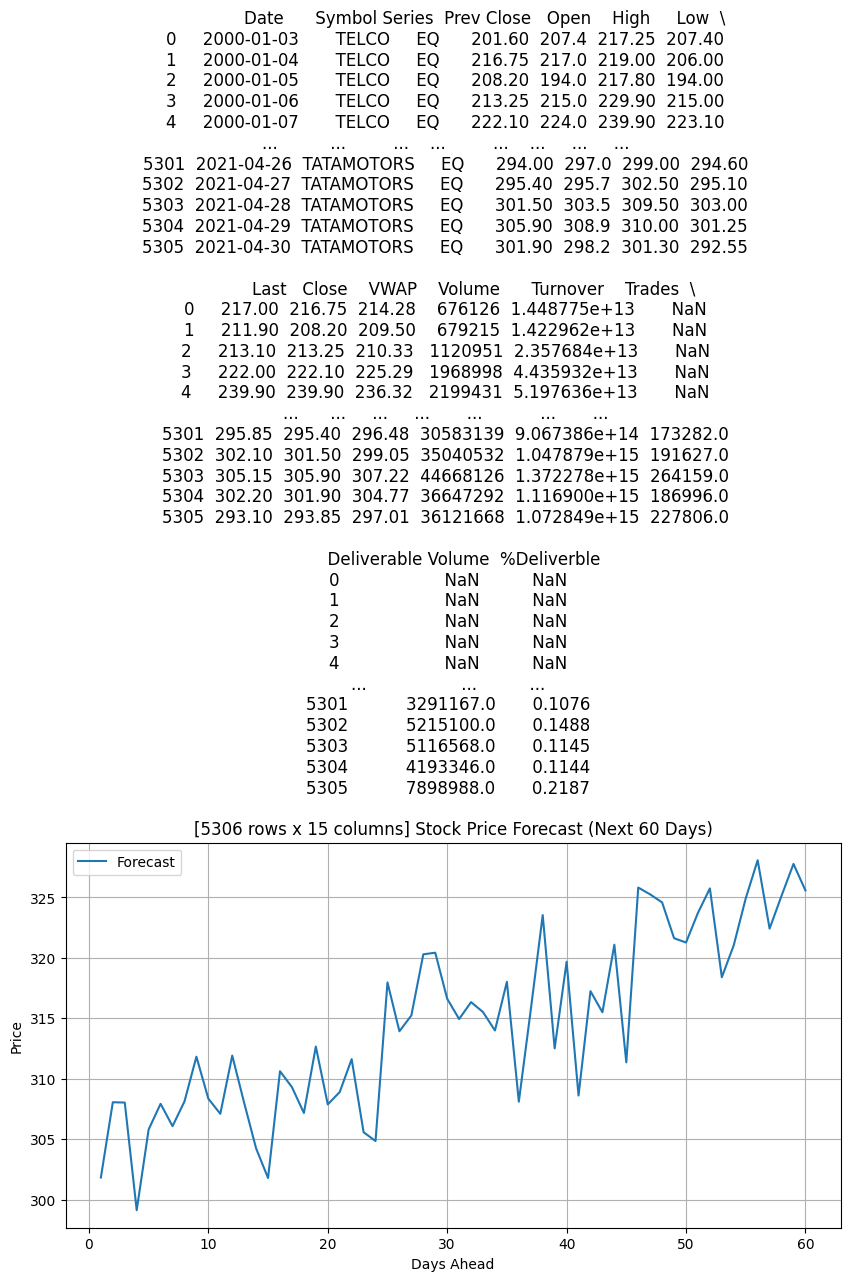

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 61), next_60, label='Forecast')
plt.title(f'{df} Stock Price Forecast (Next 60 Days)')
plt.xlabel('Days Ahead')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

**conclusion**:- Blue line shows that stock will go up !
The forecasted graph shows the expected trajectory of the stock price for the next 60 days based on the last 60 days of historical data. The model reflects recent trends but, as with all time-series models, it has limitations due to:

Market volatility

External events (news, earnings, macroeconomic shifts)

Model overfitting/underfitting

